In [26]:
# 1. IMPORTS & CHARGEMENT

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error

from nyc_zones_data import get_all_zones_df  # fichier .py

plt.style.use("seaborn-v0_8-darkgrid")

# Afficher toutes les colonnes si besoin
pd.set_option("display.max_columns", None)

# Charger le CSV
df = pd.read_csv("nyc_taxi_sample.csv")

df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               200000 non-null  int64  
 1   tpep_pickup_datetime   200000 non-null  object 
 2   tpep_dropoff_datetime  200000 non-null  object 
 3   passenger_count        200000 non-null  float64
 4   trip_distance          200000 non-null  float64
 5   RatecodeID             200000 non-null  float64
 6   store_and_fwd_flag     200000 non-null  object 
 7   PULocationID           200000 non-null  int64  
 8   DOLocationID           200000 non-null  int64  
 9   payment_type           200000 non-null  int64  
 10  fare_amount            200000 non-null  float64
 11  extra                  200000 non-null  float64
 12  mta_tax                200000 non-null  float64
 13  tip_amount             200000 non-null  float64
 14  tolls_amount           200000 non-nu

In [28]:
# 2. NETTOYAGE DE BASE & DATES

# Vérifier les infos de base
print(df.shape)
print(df.dtypes)

# Conversion en datetime
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Séparation date / heure
df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
df["pickup_time"] = df["tpep_pickup_datetime"].dt.time

df["dropoff_date"] = df["tpep_dropoff_datetime"].dt.date
df["dropoff_time"] = df["tpep_dropoff_datetime"].dt.time


# Vérifier s'il reste des valeurs manquantes
df.isna().mean().sort_values(ascending=False).head(10)


(200000, 20)
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
cbd_congestion_fee       float64
dtype: object


,0
VendorID,0.0
tpep_pickup_datetime,0.0
tpep_dropoff_datetime,0.0
passenger_count,0.0
trip_distance,0.0
RatecodeID,0.0
store_and_fwd_flag,0.0
PULocationID,0.0
DOLocationID,0.0
payment_type,0.0


In [29]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,pickup_date,pickup_time,dropoff_date,dropoff_time
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,2025-01-01,00:18:38,2025-01-01,00:26:59
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2025-01-01,00:32:40,2025-01-01,00:35:13
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0,2025-01-01,00:44:04,2025-01-01,00:46:01
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0,2025-01-01,00:14:27,2025-01-01,00:20:01
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0,2025-01-01,00:21:34,2025-01-01,00:25:06


In [40]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration_min,avg_speed_mph,price_per_mile,pu_location_id,pu_centroid_lat,pu_centroid_lon,do_location_id,do_centroid_lat,do_centroid_lon,pickup_hour,pickup_dayofweek,pickup_month,is_weekend,is_rush_hour
count,191327.000000,191327,191327,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.0,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.000000,191327.00000,191327.0,191327.00000
mean,1.780292,2025-01-02 09:28:47.220931072,2025-01-02 09:44:14.966355456,1.460029,3.737931,2.617958,162.997653,161.934432,1.253493,20.208351,1.296507,0.492562,3.414431,0.690196,0.985815,29.014634,2.275228,0.145980,0.0,15.462424,12.528410,12.882131,162.997653,40.744428,-73.909656,161.934432,40.744704,-73.909813,12.530432,2.851882,1.00115,0.0,0.23914
min,1.000000,2024-12-31 20:47:55,2024-12-31 20:54:00,0.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.0,0.033333,0.012976,0.001002,1.000000,40.575100,-74.174500,1.000000,40.552000,-74.174500,0.000000,1.000000,1.00000,0.0,0.00000
25%,2.000000,2025-01-01 16:26:13.500000,2025-01-01 16:42:26.500000,1.000000,1.050000,1.000000,132.000000,113.000000,1.000000,8.600000,0.000000,0.500000,0.000000,0.000000,1.000000,15.300000,2.500000,0.000000,0.0,7.216667,7.763905,5.411765,132.000000,40.687300,-74.004800,113.000000,40.677700,-73.993700,9.000000,2.000000,1.00000,0.0,0.00000
50%,2.000000,2025-01-02 12:57:56,2025-01-02 13:14:04,1.000000,1.800000,1.000000,161.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.650000,0.000000,1.000000,20.300000,2.500000,0.000000,0.0,12.050000,10.315789,6.923077,161.000000,40.745100,-73.862800,162.000000,40.748000,-73.885100,13.000000,3.000000,1.00000,0.0,0.00000
75%,2.000000,2025-01-02 22:04:27,2025-01-02 22:19:13,2.000000,3.700000,1.000000,231.000000,233.000000,1.000000,22.600000,2.500000,0.500000,4.260000,0.000000,1.000000,30.720000,2.500000,0.000000,0.0,19.766667,14.609517,8.780488,231.000000,40.822900,-73.848200,233.000000,40.822900,-73.848200,17.000000,3.000000,1.00000,0.0,0.00000
max,2.000000,2025-01-03 16:04:02,2025-01-03 17:30:13,9.000000,49.980000,99.000000,265.000000,265.000000,4.000000,406.000000,11.750000,0.500000,137.000000,82.690000,1.000000,420.380000,2.500000,1.750000,0.0,176.683333,73.122078,9500.000000,265.000000,41.053400,-73.518800,265.000000,41.053400,-73.518800,23.000000,4.000000,12.00000,0.0,1.00000
std,0.414050,NaN,NaN,0.907057,4.839024,12.099644,63.771701,70.205759,0.548399,19.142697,1.720404,0.060527,4.174399,2.449583,0.118254,23.779108,0.715130,0.483897,0.0,12.209255,7.594976,152.980216,63.771701,0.087409,0.102774,70.205759,0.087954,0.101239,5.958285,0.755169,0.11246,0.0,0.42656


In [31]:
# 3. VARIABLES DERIVÉES : DURÉE, VITESSE, PRIX

df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Éviter durée négative ou null
df = df[df["trip_duration_min"] > 0]

# Vitesse moyenne (miles / heure)
df["avg_speed_mph"] = df["trip_distance"] / (df["trip_duration_min"] / 60)

# Prix par mile (juste pour analyse)
df["price_per_mile"] = np.where(
    df["trip_distance"] > 0,
    df["fare_amount"] / df["trip_distance"],
    np.nan
)

df[["trip_distance", "trip_duration_min", "avg_speed_mph", "price_per_mile"]].describe()


,trip_distance,trip_duration_min,avg_speed_mph,price_per_mile
count,199924.000000,199924.000000,199924.000000,196643.000000
mean,3.708349,16.044073,12.638885,11.320592
std,4.981952,33.939978,32.577276,164.338486
min,0.000000,0.016667,0.000000,-7000.000000
25%,1.000000,7.029167,7.610884,5.263158
50%,1.780000,11.916667,10.226154,6.833333
75%,3.680000,19.700000,14.550617,8.720379
max,133.300000,2876.500000,9396.000000,9500.000000


In [32]:
# 4. FILTRAGE DES OUTLIERS SIMPLES

# Distance > 0 et raisonnable (ex: < 50 miles)
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] < 50)]

# Durée raisonnable (0 < durée < 180 min)
df = df[(df["trip_duration_min"] > 0) & (df["trip_duration_min"] < 180)]

# Vitesse raisonnable (0 < speed < 80 mph)
df = df[(df["avg_speed_mph"] > 0) & (df["avg_speed_mph"] < 80)]

# Fare_amount positifs
df = df[df["fare_amount"] > 0]

df.shape


(191327, 27)

In [33]:
# 5. AJOUT DES INFOS DE ZONES (NOMS, LAT/LON)

zones_df = get_all_zones_df()
zones_df.head()

# Jointure sur PULocationID
df = df.merge(
    zones_df.add_prefix("pu_"),
    left_on="PULocationID",
    right_on="pu_location_id",
    how="left"
)

# Jointure sur DOLocationID
df = df.merge(
    zones_df.add_prefix("do_"),
    left_on="DOLocationID",
    right_on="do_location_id",
    how="left"
)

# Vérifier
df[[
    "PULocationID", "pu_zone_name", "pu_borough",
    "DOLocationID", "do_zone_name", "do_borough"
]].head()


,PULocationID,pu_zone_name,pu_borough,DOLocationID,do_zone_name,do_borough
0,229,Edmut,Brooklyn,237,Ednarts,Bronx
1,236,Ednarton,Brooklyn,237,Ednarts,Bronx
2,141,Dyer,Bronx,141,Dyer,Bronx
3,244,Ednauts,Manhattan,244,Ednauts,Manhattan
4,244,Ednauts,Manhattan,116,Dryburgh,Staten Island


In [34]:
# 6. FEATURES TEMPORELLES (heure, jour, etc.)

df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek  # 0=lundi ... 6=dimanche
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month

df["is_weekend"] = df["pickup_dayofweek"].isin([5, 6]).astype(int)
df["is_rush_hour"] = df["pickup_hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)

df[["pickup_hour", "pickup_dayofweek", "pickup_month", "is_weekend", "is_rush_hour"]].head()


,pickup_hour,pickup_dayofweek,pickup_month,is_weekend,is_rush_hour
0,0,2,1,0,0
1,0,2,1,0,0
2,0,2,1,0,0
3,0,2,1,0,0
4,0,2,1,0,0


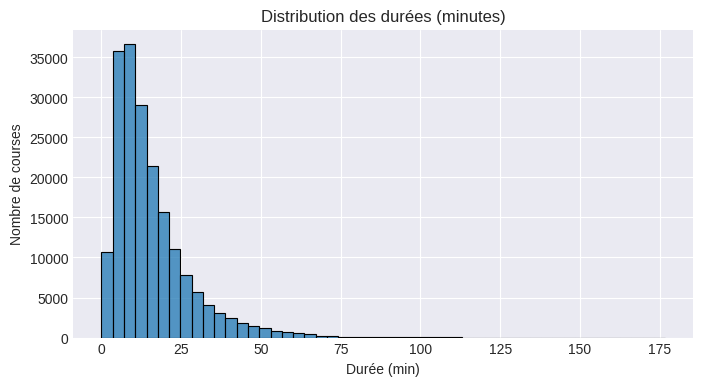

In [35]:
# 7.2 DISTRIBUTION DURÉES

plt.figure(figsize=(8, 4))
sns.histplot(df["trip_duration_min"], bins=50, kde=False)
plt.title("Distribution des durées (minutes)")
plt.xlabel("Durée (min)")
plt.ylabel("Nombre de courses")
plt.show()


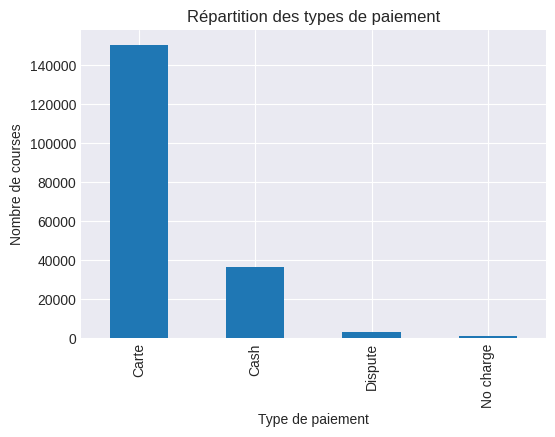

In [36]:
# 7.3 TYPES DE PAIEMENT

# Map pour rendre lisible
payment_map = {
    1: "Carte",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown"
}
df["payment_type_label"] = df["payment_type"].map(payment_map)

plt.figure(figsize=(6, 4))
df["payment_type_label"].value_counts().plot(kind="bar")
plt.title("Répartition des types de paiement")
plt.xlabel("Type de paiement")
plt.ylabel("Nombre de courses")
plt.show()


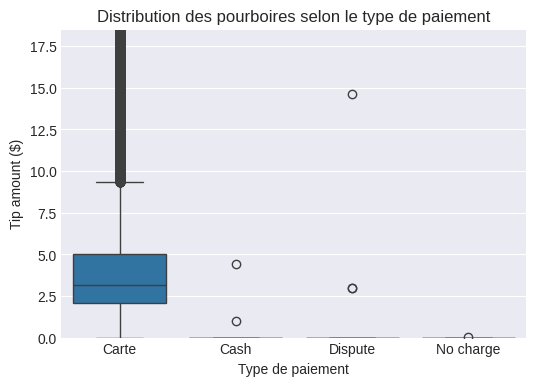

In [37]:
# 7.4 POURBOIRE SELON TYPE DE PAIEMENT

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="payment_type_label", y="tip_amount")
plt.title("Distribution des pourboires selon le type de paiement")
plt.xlabel("Type de paiement")
plt.ylabel("Tip amount ($)")
plt.ylim(0, df["tip_amount"].quantile(0.99))  # couper les extrêmes
plt.show()


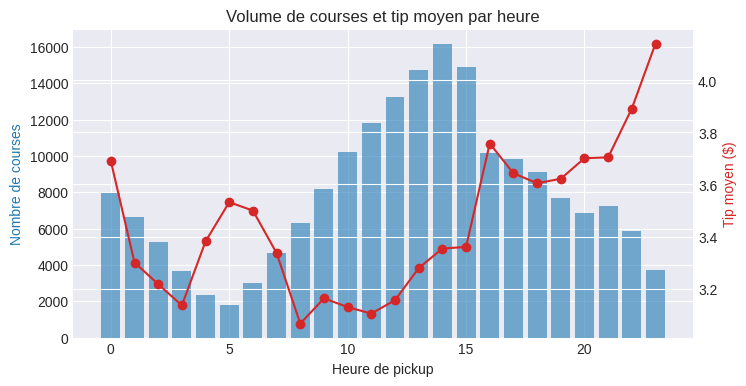

In [38]:
# 7.5 COURSES / TIPS SELON L'HEURE

hourly_stats = df.groupby("pickup_hour").agg(
    n_trips=("VendorID", "count"),
    avg_tip=("tip_amount", "mean"),
    avg_total=("total_amount", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.bar(hourly_stats["pickup_hour"], hourly_stats["n_trips"], alpha=0.6)
ax1.set_xlabel("Heure de pickup")
ax1.set_ylabel("Nombre de courses", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(hourly_stats["pickup_hour"], hourly_stats["avg_tip"], marker="o", color="tab:red")
ax2.set_ylabel("Tip moyen ($)", color="tab:red")

plt.title("Volume de courses et tip moyen par heure")
plt.show()


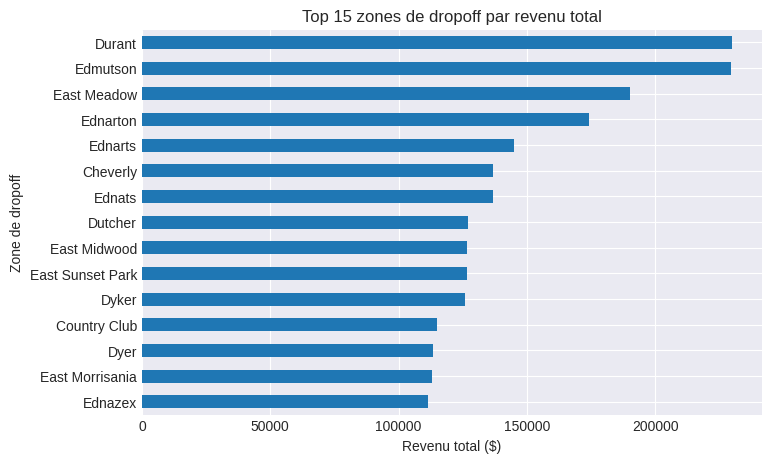

In [39]:
# 7.6 TOP ZONES (DESTINATION) PAR REVENUS

zone_revenue = (
    df.groupby("do_zone_name")["total_amount"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(8, 5))
zone_revenue.sort_values().plot(kind="barh")
plt.title("Top 15 zones de dropoff par revenu total")
plt.xlabel("Revenu total ($)")
plt.ylabel("Zone de dropoff")
plt.show()
